# Group 18 Project Report

## Introduction

The goal of this project is to answer a predictive question about a dataset concerning video game statistics gathered by computer science students at UBC. The question we aimed to answer in particular was "Can we use age and hours played to predict subscription status?" 

Below is the loaded dataset we were provided, containing many columns of variables: 4 character variables (`experience`, `hashedEmail`, `name`, `gender`), 2 double-precision variables (`played_hours`, `Age`), and 1 logical variable (`subscribe`).

In [19]:
players <- read_csv("data/players.csv")
data_summary <- summary(players)
data_summary

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:196         Length:196         Min.   : 9.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :21.14  
                                       3rd Qu.:22.75  
                                       Max.   :58.00  
                               

Focusing on our target factors (`played_hours` and `Age`), the following can be concluded :

`played_hours`:
* Minimum : 0
* Maximum : 223.10
* Mean : 5.85

`Age` :
* Minimum : 9
* Maximum : 58
* Mean : 21.14

## Methods & Results

Since we are using two of the provided numerical variables (`Age` and `played_hours`) to predict a categorical variable (`subscribe`), we will be making a K-NN classification model to understand any possible relationship between these variables.

To answer our question, we can focus on columns `subscribe`, `played_hours`, and `Age` only. 
Inside the `Age` column, there are 2 *NA*  variables. To make sure that these unknown data points would not affect our model, we first have to remove the 2 rows that contain these unknown data points. After that, we convert variables inside the `subscribe` column into a *factor*  and change `TRUE` into `Yes`, `FALSE` into `No` for easier understanding of the data.

In [20]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(themis)
options(repr.matrix.max.rows = 6)

In [21]:
data <- players |>
    select(subscribe, played_hours, Age) |>
    filter(!is.na(Age)) |>
    mutate(subscribe = as_factor(subscribe)) |>
    mutate(subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE"))
data

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
Yes,30.3,9
Yes,3.8,17
No,0.0,17
⋮,⋮,⋮
No,0.3,22
No,0.0,57
No,2.3,17


Below is a scatter plot diagram visualizing the above dataset. To produce a better scaling of the plot, we could scale `played_hours` by taking the `log(1 + played_hours)`, so that the data points are better visualized. 

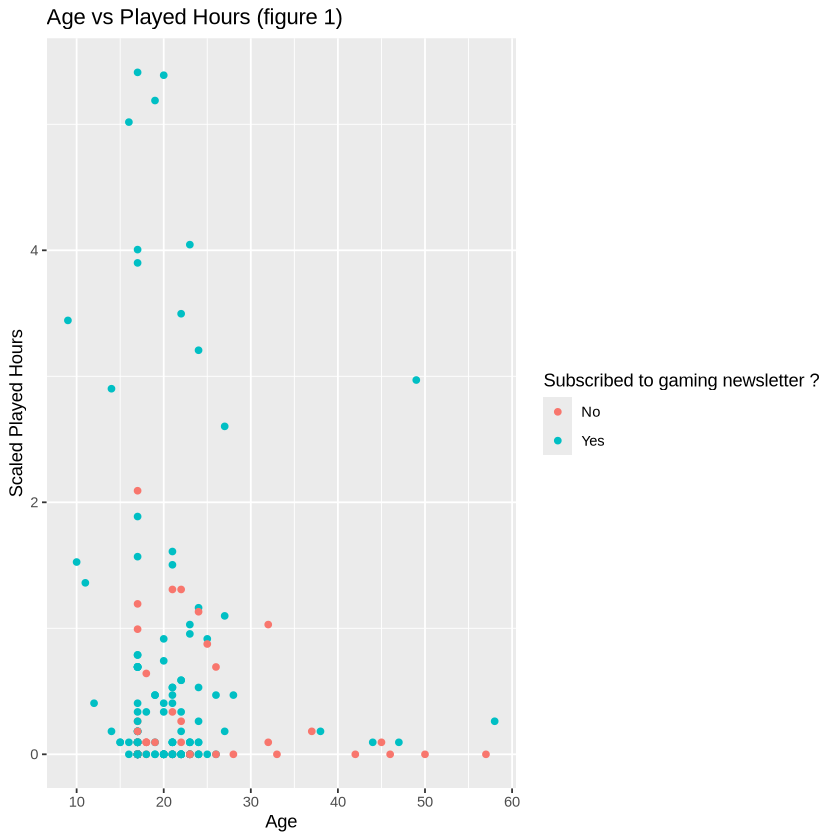

In [4]:
plot <- data |>
    ggplot(aes(x = Age, y = log1p(played_hours), colour = subscribe)) +
    geom_point() +
    labs(x = "Age", y = "Scaled Played Hours", colour = "Subscribed to gaming newsletter ?", title = "Age vs Played Hours (figure 1)")

plot

As mentioned above, we will use KNN-classification to predict whether people have subscribed to gaming newsletter based on played hours and age. We first split 80% of our original data into the training set and 20% into the testing set. Then set up a KNN model where `neighbor = tune()` to determine the best K-value to use. In our recipe, we scaled and centred our data so that all predictors are compared on a comparable scale. After that we combined our model and recipe into a workflow

In [5]:
set.seed(2000)

data_split <- initial_split(data, prop = 0.8, strata = subscribe)

train_data <- training(data_split)
test_data <- testing(data_split)

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
       set_engine("kknn") |>
       set_mode("classification") 

players_recipe <- recipe(subscribe ~ played_hours + Age, data = train_data) |>
       step_scale(all_predictors()) |>
       step_center(all_predictors())

players_workflow <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec)

players_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


To find our best K-value, we create a 10-fold cross-validation set and create a tuning grid of K-values from 1 to 30, which is  used in our cross-validation set. After training our models, we could filter out the accuracy of each K-value into a tibble.

In [6]:
set.seed(2000)

players_vfold <- vfold_cv(train_data, v = 10, strata = subscribe)

k_grid <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

accuracy <- players_workflow |>
       tune_grid(resamples = players_vfold, grid = k_grid) |>
       collect_metrics() |>
       filter(.metric == "accuracy")

accuracy

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4353922,10,0.04518375,Preprocessor1_Model01
2,accuracy,binary,0.4416422,10,0.04109135,Preprocessor1_Model02
3,accuracy,binary,0.5325245,10,0.02849596,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
28,accuracy,binary,0.7339216,10,0.003808837,Preprocessor1_Model28
29,accuracy,binary,0.7339216,10,0.003808837,Preprocessor1_Model29
30,accuracy,binary,0.7339216,10,0.003808837,Preprocessor1_Model30


From the above table, we could plot the accuracy of each K-value and visually determine which gives us the highest accuracy.

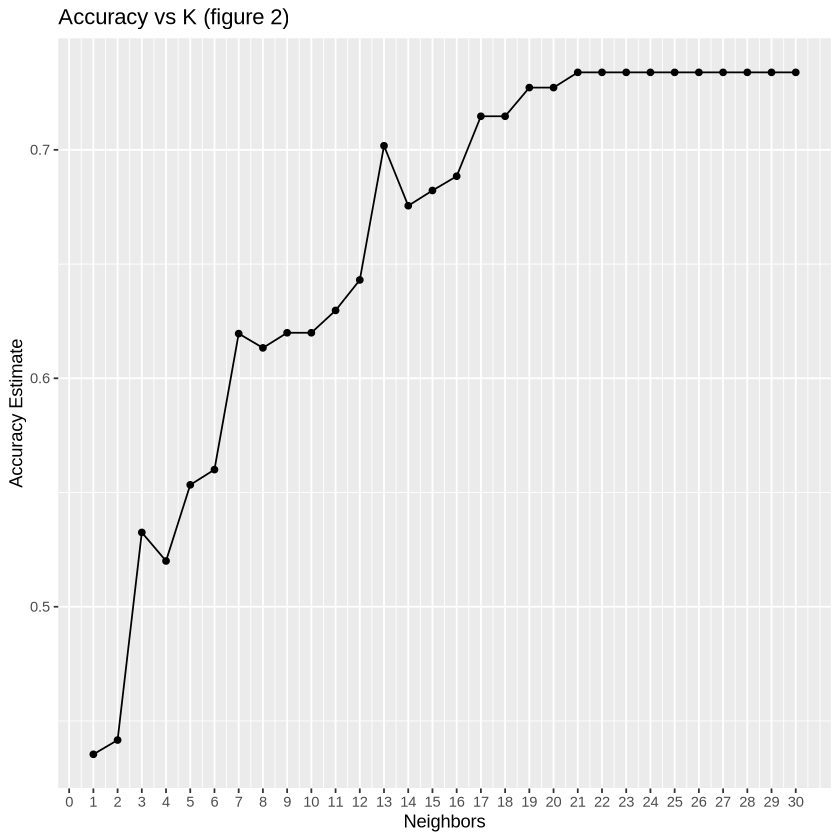

In [7]:
accuracy_versus_k <- ggplot(accuracy, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy vs K (figure 2)") +
       scale_x_continuous(breaks = seq(0, 30, by = 1))

accuracy_versus_k

K = 21 to 30 gives us the same accuracy of 0.73. In the following model, we chose K = 30 to be our best K.

In [8]:
best_players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 30) |>
    set_engine("kknn") |>
    set_mode("classification")

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(best_players_spec) |>
    fit(data = train_data)

players_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(30,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2662338
Best kernel: rectangular
Best k: 30

Using the above mode, we could check the accuracy, precision, and recall value by predicting our tesing data.

In [9]:
players_test_predictions <- predict(players_fit, test_data) |>
    bind_cols(test_data)

players_test_accuracy <- players_test_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

players_test_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.725


In [10]:
players_test_precision <- players_test_predictions |>
    precision(truth = subscribe, estimate = .pred_class, event_level = "first")

players_test_precision

Warning message:
“While computing binary `precision()`, no predicted events were detected (i.e.
`true_positive + false_positive = 0`).
Precision is undefined in this case, and `NA` will be returned.
Note that 11 true event(s) actually occurred for the problematic event level,
No”


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,NA


In [11]:
players_test_recall <- players_test_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "first")

players_test_recall

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0


In [12]:
confusion <- players_test_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)

confusion

          Truth
Prediction No Yes
       No   0   0
       Yes 11  29

Our model has a accuracy of 0.725. However, our precision is shown to be NA, and our recall value is 0. From the above confusion metric, we can see that there are 29 true positives, 0 true negatives, 11 false positives, and 0 false negatives. This could explain why our precision value is NA, and the recall is 0.

A possible reason for that is because of the imbalance of data. There is a larger proportion of `Yes` data points in our model, causing it to only predict `Yes` for every case.

To solve this issue, we can use the `step_upsample()` function to balance our data.

We use the `step_upsample()` function inside our recipe and repeat the steps we did above to figure out best K.

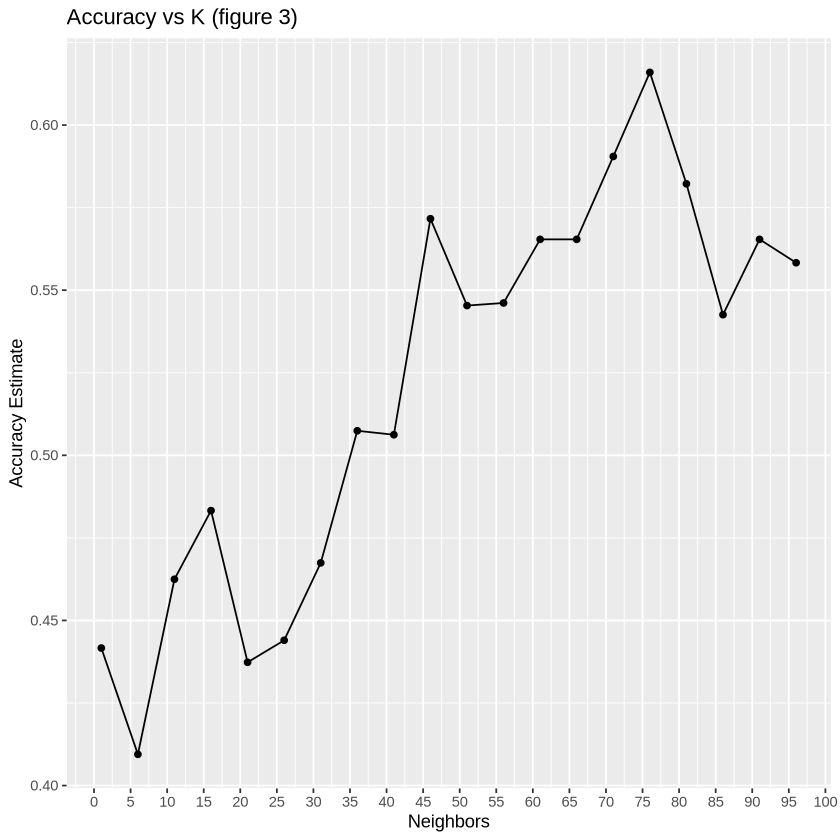

In [13]:
set.seed(3000)

players_recipe2 <- recipe(subscribe ~ played_hours + Age, data = train_data) |>
       step_upsample(subscribe) 

players_workflow2 <- workflow() |>
  add_recipe(players_recipe2) |>
  add_model(players_spec)

k_grid2 <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

accuracy2 <- players_workflow2 |>
       tune_grid(resamples = players_vfold, grid = k_grid2) |>
       collect_metrics() |>
       filter(.metric == "accuracy")

accuracy_versus_k2 <- ggplot(accuracy2, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy vs K (figure 3)") +
       scale_x_continuous(breaks = seq(0, 100, by = 5))

accuracy_versus_k2

From the graph, our best K is K = 75. We could repeat previous steps to find the accuracy, percision, and recall value of our new model.

In [14]:
best_players_spec2 <- nearest_neighbor(weight_func = "rectangular", neighbors = 75) |>
    set_engine("kknn") |>
    set_mode("classification")

players_fit2 <- workflow() |>
    add_recipe(players_recipe2) |>
    add_model(best_players_spec2) |>
    fit(data = train_data)

players_fit2

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_upsample()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(75,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.4026549
Best kernel: rectangular
Best k: 75

In [15]:
players_test_predictions2 <- predict(players_fit2, test_data) |>
    bind_cols(test_data)

players_test_accuracy2 <- players_test_predictions2 |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

players_test_accuracy2

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.525


In [16]:
players_test_precision2 <- players_test_predictions2 |>
    precision(truth = subscribe, estimate = .pred_class, event_level = "first")

players_test_precision2

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.2777778


In [17]:
players_test_recall2 <- players_test_predictions2 |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "first")

players_test_recall2

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.4545455


In [18]:
confusion2 <- players_test_predictions2 |>
    conf_mat(truth = subscribe, estimate = .pred_class)

confusion2

          Truth
Prediction No Yes
       No   5  13
       Yes  6  16

After upsampling our data, both our precision and recall value went up. However, our accuracy went down. This is because our data is no longer being dominated by either variable. 

## Discussion

#### Summary of findings

It is shown that the poportion of data do affect the performace of a model. 

Before fixing the imbalance of the two classes (`Yes` and `No`), the model have its best K = 30, with a cross-validation accuracy of 0.725. However, its precision was NA and recall was 0. This indicates that the model only predicts `Yes` for all scenarios. The model had never predicted the minority class `No` due to the imbalance ratio to the two classes.

After upsampling the training data, the model's best K-value increased to K = 75. The accuracy of the model dropped to 0.525, but it achieved a precision of 0.278 and recall of 0.455. This means that the model can now predict `No` classes due to the balancing of both classes. 

#### Expectation of findings

When deciding on the question, we thought `Age` and `played_hours` would show a relationship that we could easily predict whether they have subscribed to a newsletter or not. We expected the accuracy of our model would be fairly high. 

But as we progressed, we realized that the variables show no obvious relationship and noticed the imbalance of `Yes` `No` classes. The accuracy of our model before upsampling did had a decent accuracy like we expected but not in a good way.

#### Impact of findings

Our findings shows that a high accuracy model is not necessary the best model. Our model's accuracy before upsampling was 0.725 but it favoured predicting a single class. The model failed to predict the minority class due to the imbalanced poportion. After upsampling, although the accuracy decreased, both precision and recall increase. This indicates that the model is capable of predicting both classes, improving in fairness and usefulness.

#### Future questions

Our current model still needs improvement. Given that `Age` and `played_hours` showed no obvious relationship, will using other factors to predict `subscribe` could produce a better model? Even with upsampling the training data, the model's accuracy is still not high enough to produce accurate predictions. Is there ways to improve this issue beyond our current skills?